**COMS 6998: High Performance Machine Learning**<br>
Homework Assignment 01 - Due: Oct 01, 11:59pm ET<br>
Completed in Colab Environment w/TPU Runtime

Stephen V. Wright (svw2112)

**Final Results (C1-C5):**

dp1: Vector size: 1000000 with 1000 measurements.  
N: 1000000 T: 0.001678 sec B: 4.440 GB/sec F: 1191738180.203 FLOP/sec

dp1: Vector size: 300000000 with 20 measurements.  
N: 300000000 T: 0.496774 sec B: 4.499 GB/sec F: 1207793347.447 FLOP/sec

dp2: Vector size: 1000000 with 1000 measurements.  
N: 1000000 T: 0.000777 sec B: 9.591 GB/sec F: 2574610957.554 FLOP/sec

dp2: Vector size: 300000000 with 20 measurements.  
N: 300000000 T: 0.259098 sec B: 8.627 GB/sec F: 2315727082.634 FLOP/sec

dp3: Vector size: 1000000 with 1000 measurements.  
N: 1000000 T: 0.000412 sec B: 18.085 GB/sec F: 4854645953.298 FLOP/sec

dp3: Vector size: 300000000 with 20 measurements.  
N: 300000000 T: 0.243238 sec B: 9.189 GB/sec F: 2466717159.903 FLOP/sec

dp4: Vector size: 1000000 with 1000 measurements.  
N: 1000000 T: 0.551437 sec B: 0.014 GB/sec F: 3626885.618 FLOP/sec

dp4: Vector size: 300000000 with 20 measurements.  
N: 300000000 T: 164.277968 sec B: 0.014 GB/sec F: 3652346.133 FLOP/sec

dp5: Vector size: 1000000 with 1000 measurements.  
N: 1000000 T: 0.000702 sec B: 10.882 GB/sec F: 2921165255.164 FLOP/sec

dp5: Vector size: 300000000 with 20 measurements.  
N: 300000000 T: 0.254822 sec B: 8.815 GB/sec F: 2366349779.493 FLOP/sec


**Note:** There are two implementations for dp1 and dp2 in this notebook; the reported final results include an optimized version of dp1 and dp2 that attempts to mitigate precision losses, while the initial dp1_test and dp2_test implementations included at the end of this notebook contain no such optimization efforts and observe the expected precision losses.

In [ ]:
!echo "deb https://apt.repos.intel.com/oneapi all main" | tee /etc/apt/sources.list.d/oneAPI.list
!wget https://apt.repos.intel.com/intel-gpg-keys/GPG-PUB-KEY-INTEL-SW-PRODUCTS-2023.PUB -O- | apt-key add -
!apt-get update
!apt-get install intel-oneapi-mkl-devel -y

**C1:** Write a micro-benchmark that investigates the performance of computing the dot-product in C that takes two arrays of ’float’ (32 bit) as input. The dimension of the vector space and the number of repetitions for the measurement are command line arguments, i.e. a call ’dp1 1000 10’ performs 10 measurements on a dot product with vectors of size 1000. Initialize fields in the input vectors to 1.0.

```
float dp(long N, float *pA, float *pB) {
  float R = 0.0;
  int j;
  for (j=0;j<N;j++)
    R += pA[j]*pB[j];
  return R; }
```

Name the program dp1.c and compile with gcc -O3 -Wall -o dp1 dp1.c.

Make sure the code is executed on a platform that has enough RAM. The 300000000 size runs should not be killed by the system!

Measure the execution time of the function with clock gettime(CLOCK MONOTONIC).

Measure the time for N=1000000 and N=300000000. Perform 1000 repetitions for the small case and 20 repetitions for the large case. Compute the appropriate mean for the execution time for the second half of the repetitions.

For the average times, compute the bandwidth in GB/sec and throughput in FLOP/sec, print the result as:

N: 1000000 <T>: 9.999999 sec B: 9.999 GB/sec F: 9.999 FLOP/sec
N: 300000000 <T>: 9.999999 sec B: 9.999 GB/sec F: 9.999 FLOP/sec

In [52]:
%%writefile dp1.c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#define GB (1073741824.0) // Constant for gigabyte conversion

// Compute the dot product of two vectors
float dp(long N, float *pA, float *pB)
{
    float R = 0.0;
    for (long j = 0; j < N; j++)
        R += pA[j] * pB[j];
    return R;
}

// Compute the dot product of two vectors in chunks to avoid precision issues
float dp_chunked(long N, float *pA, float *pB)
{
    long chunk_size = 16777216; // size chosen based on precision limit of float
    float R = 0.0;
    for (long i = 0; i < N; i += chunk_size)
    {
        long current_chunk_size = (N - i > chunk_size) ? chunk_size : (N - i);
        R += dp(current_chunk_size, pA + i, pB + i);
    }
    return R;
}

// Initialize two vectors with all elements set to 1
void initialize_vectors(long N, float *vecA, float *vecB)
{
    for (long i = 0; i < N; i++)
    {
        vecA[i] = 1.0;
        vecB[i] = 1.0;
    }
}

int main(int argc, char *argv[])
{
    // Check for the correct number of command-line arguments
    if (argc < 3)
    {
        printf("Usage: %s [vector size] [number of measurements]\n", argv[0]);
        return 1;
    }

    // Convert command-line arguments to respective data types
    long vec_size = atol(argv[1]);
    int num_measurements = atoi(argv[2]);
    printf("Vector size: %ld with %d measurements.\n", vec_size, num_measurements);

    // Allocate memory for the two vectors
    float *vecA = (float *)malloc(vec_size * sizeof(float));
    float *vecB = (float *)malloc(vec_size * sizeof(float));

    // Initialize vectors to default values
    initialize_vectors(vec_size, vecA, vecB);

    struct timespec start_time, end_time;
    double cumulative_time = 0;
    float dp_result;

    // Perform the dot product multiple times and measure its performance
    for (int i = 0; i < num_measurements; i++)
    {
        clock_gettime(CLOCK_MONOTONIC, &start_time); // Start the timer

        // Chunked version for large vectors, unrolled for smaller vectors
        if (vec_size > 16777216)
            dp_result = dp_chunked(vec_size, vecA, vecB);
        else
            dp_result = dp(vec_size, vecA, vecB);

        clock_gettime(CLOCK_MONOTONIC, &end_time); // Stop the timer

        // Calculate elapsed time
        double elapsed_time = (end_time.tv_sec - start_time.tv_sec) +
                              (end_time.tv_nsec - start_time.tv_nsec) / 1e9;

        // Accumulate time from the second half measurements for averages
        if (i >= num_measurements / 2)
            cumulative_time += elapsed_time;

        // Compute bandwidth and flops
        double bandwidth = (vec_size * 2 * sizeof(float) / GB) / elapsed_time;
        double flops = vec_size * 2 / elapsed_time;

        printf("R: %ld <T>: %.6f sec B: %.3f GB/sec F: %.3f FLOP/sec\n",
               (long)dp_result, elapsed_time, bandwidth, flops);
    }

    // Calculate and print the averages for the second half measurements
    double average_time = cumulative_time / (num_measurements / 2);
    double average_bandwidth = (vec_size * 2 * sizeof(float) / GB) / average_time;
    double average_flops = vec_size * 2 / average_time;

    printf("N: %li <T>: %.6f sec B: %.3f GB/sec F: %.3f FLOP/sec\n",
           vec_size, average_time, average_bandwidth, average_flops);

    // Free the allocated memory
    free(vecA);
    free(vecB);

    return 0;
}

Overwriting dp1.c


In [53]:
!gcc -O3 -Wall -o dp1 dp1.c

In [54]:
!./dp1

Usage: ./dp1 [vector size] [number of measurements]


In [55]:
!./dp1 1000000 1000

Vector size: 1000000 with 1000 measurements.
R: 1000000 <T>: 0.001648 sec B: 4.521 GB/sec F: 1213579714.287 FLOP/sec
R: 1000000 <T>: 0.001664 sec B: 4.477 GB/sec F: 1201696314.518 FLOP/sec
R: 1000000 <T>: 0.002203 sec B: 3.382 GB/sec F: 907720251.511 FLOP/sec
R: 1000000 <T>: 0.001699 sec B: 4.386 GB/sec F: 1177388951.618 FLOP/sec
R: 1000000 <T>: 0.002072 sec B: 3.596 GB/sec F: 965180160.529 FLOP/sec
R: 1000000 <T>: 0.001965 sec B: 3.792 GB/sec F: 1017975927.923 FLOP/sec
R: 1000000 <T>: 0.001609 sec B: 4.630 GB/sec F: 1242978723.933 FLOP/sec
R: 1000000 <T>: 0.001981 sec B: 3.761 GB/sec F: 1009692543.572 FLOP/sec
R: 1000000 <T>: 0.001613 sec B: 4.620 GB/sec F: 1240211629.712 FLOP/sec
R: 1000000 <T>: 0.001629 sec B: 4.573 GB/sec F: 1227600887.310 FLOP/sec
R: 1000000 <T>: 0.001574 sec B: 4.734 GB/sec F: 1270682744.192 FLOP/sec
R: 1000000 <T>: 0.001628 sec B: 4.575 GB/sec F: 1228176832.900 FLOP/sec
R: 1000000 <T>: 0.001601 sec B: 4.653 GB/sec F: 1248969600.080 FLOP/sec
R: 1000000 <T>: 0.001

In [56]:
!./dp1 300000000 20

Vector size: 300000000 with 20 measurements.
R: 300000000 <T>: 0.499813 sec B: 4.472 GB/sec F: 1200448696.511 FLOP/sec
R: 300000000 <T>: 0.500948 sec B: 4.462 GB/sec F: 1197730226.961 FLOP/sec
R: 300000000 <T>: 0.499447 sec B: 4.475 GB/sec F: 1201327830.053 FLOP/sec
R: 300000000 <T>: 0.504777 sec B: 4.428 GB/sec F: 1188644833.118 FLOP/sec
R: 300000000 <T>: 0.497842 sec B: 4.490 GB/sec F: 1205201333.191 FLOP/sec
R: 300000000 <T>: 0.497761 sec B: 4.490 GB/sec F: 1205396831.624 FLOP/sec
R: 300000000 <T>: 0.498931 sec B: 4.480 GB/sec F: 1202572263.590 FLOP/sec
R: 300000000 <T>: 0.494874 sec B: 4.517 GB/sec F: 1212428958.432 FLOP/sec
R: 300000000 <T>: 0.494182 sec B: 4.523 GB/sec F: 1214126456.018 FLOP/sec
R: 300000000 <T>: 0.494741 sec B: 4.518 GB/sec F: 1212754625.287 FLOP/sec
R: 300000000 <T>: 0.494501 sec B: 4.520 GB/sec F: 1213343963.790 FLOP/sec
R: 300000000 <T>: 0.496422 sec B: 4.503 GB/sec F: 1208649536.028 FLOP/sec
R: 300000000 <T>: 0.499482 sec B: 4.475 GB/sec F: 1201245047.247 FL

In [57]:
import numpy as np

def compute_dot_product(N):
    # Create two vectors of size N with all elements set to 1.0
    vecA = np.ones(N, dtype=np.float32)  # Using float32 to mimic single-precision float in C
    vecB = np.ones(N, dtype=np.float32)

    # Compute the dot product using numpy
    dot_product_result = np.dot(vecA, vecB)

    # Analytically, the result should be N
    analytical_result = N

    return dot_product_result, analytical_result

# Test the function for a few vector sizes
vector_sizes = [1000000, 16777216, 67108864, 300000000]
results = {}

for size in vector_sizes:
    dot_product_result, analytical_result = compute_dot_product(size)
    results[size] = (dot_product_result, analytical_result)

for size, (dp_result, analytical) in results.items():
    print(f"For N = {size}:")
    print(f"Computed Dot Product: {dp_result}")
    print(f"Analytical Result: {analytical}")
    print("----")

For N = 1000000:
Computed Dot Product: 1000000.0
Analytical Result: 1000000
----
For N = 16777216:
Computed Dot Product: 16777216.0
Analytical Result: 16777216
----
For N = 67108864:
Computed Dot Product: 67108864.0
Analytical Result: 67108864
----
For N = 300000000:
Computed Dot Product: 300000000.0
Analytical Result: 300000000
----


**C2:** Perform the same microbenchmark.

```
float dpunroll(long N, float *pA, float *pB) {
  float R = 0.0;
  int j;
  for (j=0;j<N;j+=4)
    R += pA[j]*pB[j] + pA[j+1]*pB[j+1] \
           + pA[j+2]*pB[j+2] + pA[j+3] * pB[j+3];
  return R; }
```

In [58]:
%%writefile dp2.c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#define GB (1073741824.0)   // Constant for gigabyte conversion
#define CHUNK_SIZE 16777216 // Chunk size for precision control

// Compute the dot product of two vectors using loop unrolling for optimization
float dpunroll(long N, float *pA, float *pB)
{
    float R = 0.0;
    int j;
    for (j = 0; j < N; j += 4)
        R += pA[j] * pB[j] + pA[j + 1] * pB[j + 1] +
             pA[j + 2] * pB[j + 2] + pA[j + 3] * pB[j + 3];
    return R;
}

// Compute the dot product of two vectors in chunks to avoid precision issues
float dpunroll_chunked(long N, float *pA, float *pB)
{
    float R = 0.0;
    for (long i = 0; i < N; i += CHUNK_SIZE)
    {
        long current_chunk_size = (N - i > CHUNK_SIZE) ? CHUNK_SIZE : (N - i);
        R += dpunroll(current_chunk_size, pA + i, pB + i);
    }
    return R;
}

// Initialize two vectors with all elements set to 1
void initialize_vectors(long N, float *vecA, float *vecB)
{
    for (long i = 0; i < N; i++)
    {
        vecA[i] = 1.0;
        vecB[i] = 1.0;
    }
}

int main(int argc, char *argv[])
{
    // Check for the correct number of command-line arguments
    if (argc < 3)
    {
        printf("Usage: %s [vector size] [number of measurements]\n", argv[0]);
        return 1;
    }

    // Convert command-line arguments to respective data types
    long vec_size = atol(argv[1]);
    int num_measurements = atoi(argv[2]);
    printf("Vector size: %ld with %d measurements.\n", vec_size, num_measurements);

    // Allocate memory for the two vectors
    float *vecA = (float *)malloc(vec_size * sizeof(float));
    float *vecB = (float *)malloc(vec_size * sizeof(float));

    // Initialize vectors to default values
    initialize_vectors(vec_size, vecA, vecB);

    struct timespec start_time, end_time;
    double cumulative_time = 0;
    float dp_result;

    // Perform the dot product multiple times and measure its performance
    for (int i = 0; i < num_measurements; i++)
    {
        clock_gettime(CLOCK_MONOTONIC, &start_time); // Start the timer

        // Chunked version for large vectors, unrolled for smaller vectors
        if (vec_size > CHUNK_SIZE)
            dp_result = dpunroll_chunked(vec_size, vecA, vecB);
        else
            dp_result = dpunroll(vec_size, vecA, vecB);

        clock_gettime(CLOCK_MONOTONIC, &end_time); // Stop the timer

        // Calculate elapsed time
        double elapsed_time = (end_time.tv_sec - start_time.tv_sec) +
                              (end_time.tv_nsec - start_time.tv_nsec) / 1e9;

        // Accumulate time from the second half measurements for averages
        if (i >= num_measurements / 2)
            cumulative_time += elapsed_time;

        // Compute bandwidth and flops
        double bandwidth = (vec_size * 2 * sizeof(float) / GB) / elapsed_time;
        double flops = vec_size * 2 / elapsed_time;

        printf("R: %ld <T>: %.6f sec B: %.3f GB/sec F: %.3f FLOP/sec\n",
               (long)dp_result, elapsed_time, bandwidth, flops);
    }

    // Calculate and print the averages for the second half measurements
    double average_time = cumulative_time / (num_measurements / 2);
    double average_bandwidth = (vec_size * 2 * sizeof(float) / GB) / average_time;
    double average_flops = vec_size * 2 / average_time;

    printf("N: %li <T>: %.6f sec B: %.3f GB/sec F: %.3f FLOP/sec\n",
           vec_size, average_time, average_bandwidth, average_flops);

    // Free the allocated memory
    free(vecA);
    free(vecB);

    return 0;
}

Overwriting dp2.c


In [59]:
!gcc -O3 -Wall -o dp2 dp2.c

In [60]:
!./dp2

Usage: ./dp2 [vector size] [number of measurements]


In [62]:
!./dp2 1000000 1000

Vector size: 1000000 with 1000 measurements.
R: 1000000 <T>: 0.001058 sec B: 7.039 GB/sec F: 1889550126.458 FLOP/sec
R: 1000000 <T>: 0.000993 sec B: 7.503 GB/sec F: 2014019590.369 FLOP/sec
R: 1000000 <T>: 0.001010 sec B: 7.376 GB/sec F: 1979984338.324 FLOP/sec
R: 1000000 <T>: 0.000876 sec B: 8.501 GB/sec F: 2282016115.598 FLOP/sec
R: 1000000 <T>: 0.001659 sec B: 4.492 GB/sec F: 1205765730.570 FLOP/sec
R: 1000000 <T>: 0.001289 sec B: 5.778 GB/sec F: 1551127087.720 FLOP/sec
R: 1000000 <T>: 0.004866 sec B: 1.531 GB/sec F: 411022978.651 FLOP/sec
R: 1000000 <T>: 0.000898 sec B: 8.299 GB/sec F: 2227876076.621 FLOP/sec
R: 1000000 <T>: 0.000853 sec B: 8.736 GB/sec F: 2345097515.017 FLOP/sec
R: 1000000 <T>: 0.000809 sec B: 9.212 GB/sec F: 2472857300.060 FLOP/sec
R: 1000000 <T>: 0.000763 sec B: 9.760 GB/sec F: 2619810482.910 FLOP/sec
R: 1000000 <T>: 0.000758 sec B: 9.835 GB/sec F: 2640065368.019 FLOP/sec
R: 1000000 <T>: 0.000774 sec B: 9.622 GB/sec F: 2583001525.262 FLOP/sec
R: 1000000 <T>: 0.00

In [63]:
!./dp2 300000000 20

Vector size: 300000000 with 20 measurements.
R: 300000000 <T>: 0.262639 sec B: 8.510 GB/sec F: 2284506299.703 FLOP/sec
R: 300000000 <T>: 0.276358 sec B: 8.088 GB/sec F: 2171094663.686 FLOP/sec
R: 300000000 <T>: 0.281734 sec B: 7.934 GB/sec F: 2129669113.629 FLOP/sec
R: 300000000 <T>: 0.286376 sec B: 7.805 GB/sec F: 2095149276.872 FLOP/sec
R: 300000000 <T>: 0.274113 sec B: 8.154 GB/sec F: 2188881455.529 FLOP/sec
R: 300000000 <T>: 0.278223 sec B: 8.034 GB/sec F: 2156542965.014 FLOP/sec
R: 300000000 <T>: 0.263854 sec B: 8.471 GB/sec F: 2273981856.081 FLOP/sec
R: 300000000 <T>: 0.263556 sec B: 8.481 GB/sec F: 2276554376.216 FLOP/sec
R: 300000000 <T>: 0.271383 sec B: 8.236 GB/sec F: 2210893896.681 FLOP/sec
R: 300000000 <T>: 0.264879 sec B: 8.438 GB/sec F: 2265188305.614 FLOP/sec
R: 300000000 <T>: 0.257789 sec B: 8.671 GB/sec F: 2327487327.811 FLOP/sec
R: 300000000 <T>: 0.259639 sec B: 8.609 GB/sec F: 2310904393.695 FLOP/sec
R: 300000000 <T>: 0.256021 sec B: 8.730 GB/sec F: 2343554249.139 FL

In [64]:
import numpy as np

def compute_dot_product_unrolled(N):
    # Create two vectors of size N with all elements set to 1.0
    vecA = np.ones(N, dtype=np.float32)  # Using float32 to mimic single-precision float in C
    vecB = np.ones(N, dtype=np.float32)

    # Compute the dot product using loop unrolling
    dot_product_result = 0.0
    for j in range(0, N, 4):
        dot_product_result += (vecA[j] * vecB[j] +
                               vecA[j + 1] * vecB[j + 1] +
                               vecA[j + 2] * vecB[j + 2] +
                               vecA[j + 3] * vecB[j + 3])

    # Analytically, the result should be N
    analytical_result = N

    return dot_product_result, analytical_result

# Test the function for a few vector sizes
vector_sizes = [1000000, 16777216, 67108864, 300000000]
results = {}

for size in vector_sizes:
    dot_product_result, analytical_result = compute_dot_product_unrolled(size)
    results[size] = (dot_product_result, analytical_result)

for size, (dp_result, analytical) in results.items():
    print(f"For N = {size}:")
    print(f"Computed Dot Product: {dp_result}")
    print(f"Analytical Result: {analytical}")
    print("----")


For N = 1000000:
Computed Dot Product: 1000000.0
Analytical Result: 1000000
----
For N = 16777216:
Computed Dot Product: 16777216.0
Analytical Result: 16777216
----
For N = 67108864:
Computed Dot Product: 67108864.0
Analytical Result: 67108864
----
For N = 300000000:
Computed Dot Product: 300000000.0
Analytical Result: 300000000
----


**C3:** Perform the same microbenchmark with MKL (Intel library), you may need to install a module to access MKL.

```
#include <mkl_cblas.h>
float bdp(long N, float *pA, float *pB) {
  float R = cblas_sdot(N, pA, 1, pB, 1);
  return R; }
```

In [70]:
%%writefile dp3.c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <mkl_cblas.h>

#define GB (1073741824.0) // Constant for gigabyte conversion

// Compute the dot product of two vectors using the Intel MKL library
float bdp(long N, float *pA, float *pB)
{
    float R = cblas_sdot(N, pA, 1, pB, 1);
    return R;
}

// Initialize two vectors with all elements set to 1
void initialize_vectors(long N, float *vecA, float *vecB)
{
    for (long idx = 0; idx < N; idx++)
    {
        vecA[idx] = 1.0;
        vecB[idx] = 1.0;
    }
}

int main(int argc, char *argv[])
{
    // Check for the correct number of command-line arguments
    if (argc != 3)
    {
        fprintf(stderr, "Usage: %s <vector_size> <measurements>\n", argv[0]);
        return 1;
    }

    // Convert command-line arguments to respective data types
    long vector_size = atol(argv[1]);
    int num_measurements = atoi(argv[2]);

    // Print the vector size and number of measurements
    printf("Vector size: %ld with %d measurements.\n", vector_size, num_measurements);

    // Allocate memory for the two vectors
    float *vecA = (float *)malloc(vector_size * sizeof(float));
    float *vecB = (float *)malloc(vector_size * sizeof(float));

    // Initialize vectors to default values
    initialize_vectors(vector_size, vecA, vecB);

    struct timespec start, end;
    double cumulative_time = 0.0;

    // Perform the dot product multiple times and measure its performance
    for (int measure = 0; measure < num_measurements; measure++)
    {
        clock_gettime(CLOCK_MONOTONIC, &start); // Start the timer
        float result = bdp(vector_size, vecA, vecB);
        clock_gettime(CLOCK_MONOTONIC, &end); // Stop the timer

        // Calculate elapsed time
        double elapsed_time = ((double)end.tv_sec + 1.0e-9 * end.tv_nsec) -
                              ((double)start.tv_sec + 1.0e-9 * start.tv_nsec);

        // Accumulate time from the second half measurements for averages
        if (measure >= num_measurements / 2)
        {
            cumulative_time += elapsed_time;
        }

        // Compute bandwidth and flops
        double bandwidth = (vector_size * 2 * sizeof(float) / GB) / elapsed_time;
        double flops = vector_size * 2 / elapsed_time;

        printf("R: %ld <T>: %.6f sec B: %.3f GB/sec F: %.3f FLOP/sec\n",
               (long)result, elapsed_time, bandwidth, flops);
    }

    // Calculate and print the averages for the second half measurements
    double mean_time = cumulative_time / (num_measurements / 2);
    double mean_bandwidth = (vector_size * 2 * sizeof(float) / GB) / mean_time;
    double mean_flops = vector_size * 2 / mean_time;

    printf("N: %li <T>: %.6f sec B: %.3f GB/sec F: %.3f FLOP/sec\n",
           vector_size, mean_time, mean_bandwidth, mean_flops);

    // Free the allocated memory
    free(vecA);
    free(vecB);

    return 0;
}

Overwriting dp3.c


In [71]:
!find /usr -name "mkl_cblas.h"

/usr/include/mkl/mkl_cblas.h


In [72]:
!find /usr -name "libmkl_rt.so"

/usr/lib/x86_64-linux-gnu/libmkl_rt.so


In [73]:
!gcc -O3 -Wall -o dp3 dp3.c -I /usr/include/mkl -L /usr/lib/x86_64-linux-gnu -lmkl_rt

In [74]:
!./dp3 1000000 1000

Vector size: 1000000 with 1000 measurements.
R: 1000000 <T>: 0.019885 sec B: 0.375 GB/sec F: 100579094.195 FLOP/sec
R: 1000000 <T>: 0.000672 sec B: 11.081 GB/sec F: 2974552698.289 FLOP/sec
R: 1000000 <T>: 0.000491 sec B: 15.163 GB/sec F: 4070401662.196 FLOP/sec
R: 1000000 <T>: 0.000429 sec B: 17.380 GB/sec F: 4665332379.208 FLOP/sec
R: 1000000 <T>: 0.000390 sec B: 19.082 GB/sec F: 5122229201.582 FLOP/sec
R: 1000000 <T>: 0.000360 sec B: 20.672 GB/sec F: 5549050833.542 FLOP/sec
R: 1000000 <T>: 0.000415 sec B: 17.932 GB/sec F: 4813524069.813 FLOP/sec
R: 1000000 <T>: 0.000361 sec B: 20.625 GB/sec F: 5536531416.800 FLOP/sec
R: 1000000 <T>: 0.000374 sec B: 19.934 GB/sec F: 5350898557.480 FLOP/sec
R: 1000000 <T>: 0.000371 sec B: 20.073 GB/sec F: 5388264903.992 FLOP/sec
R: 1000000 <T>: 0.000381 sec B: 19.533 GB/sec F: 5243233598.846 FLOP/sec
R: 1000000 <T>: 0.000510 sec B: 14.616 GB/sec F: 3923476516.044 FLOP/sec
R: 1000000 <T>: 0.000790 sec B: 9.437 GB/sec F: 2533130173.548 FLOP/sec
R: 100000

In [75]:
!./dp3 300000000 20

Vector size: 300000000 with 20 measurements.
R: 300000000 <T>: 0.254314 sec B: 8.789 GB/sec F: 2359289478.587 FLOP/sec
R: 300000000 <T>: 0.249104 sec B: 8.973 GB/sec F: 2408635053.015 FLOP/sec
R: 300000000 <T>: 0.231816 sec B: 9.642 GB/sec F: 2588262646.465 FLOP/sec
R: 300000000 <T>: 0.223913 sec B: 9.982 GB/sec F: 2679618142.445 FLOP/sec
R: 300000000 <T>: 0.229305 sec B: 9.748 GB/sec F: 2616606963.327 FLOP/sec
R: 300000000 <T>: 0.234643 sec B: 9.526 GB/sec F: 2557074673.850 FLOP/sec
R: 300000000 <T>: 0.221434 sec B: 10.094 GB/sec F: 2709605716.200 FLOP/sec
R: 300000000 <T>: 0.219261 sec B: 10.194 GB/sec F: 2736460255.764 FLOP/sec
R: 300000000 <T>: 0.217278 sec B: 10.287 GB/sec F: 2761435983.161 FLOP/sec
R: 300000000 <T>: 0.219270 sec B: 10.194 GB/sec F: 2736347700.050 FLOP/sec
R: 300000000 <T>: 0.221392 sec B: 10.096 GB/sec F: 2710122187.127 FLOP/sec
R: 300000000 <T>: 0.212979 sec B: 10.495 GB/sec F: 2817174449.530 FLOP/sec
R: 300000000 <T>: 0.224146 sec B: 9.972 GB/sec F: 2676824824.

In [76]:
import numpy as np

def compute_dot_product_mkl(N):
    # Create two vectors of size N with all elements set to 1.0
    vecA = np.ones(N, dtype=np.float32)  # Using float32 to mimic single-precision float in C
    vecB = np.ones(N, dtype=np.float32)

    # Compute the dot product using numpy (which uses MKL under the hood)
    dot_product_result = np.dot(vecA, vecB)

    # Analytically, the result should be N
    analytical_result = N

    return dot_product_result, analytical_result

# Test the function for a few vector sizes
vector_sizes = [1000000, 16777216, 67108864, 300000000]
results = {}

for size in vector_sizes:
    dot_product_result, analytical_result = compute_dot_product_mkl(size)
    results[size] = (dot_product_result, analytical_result)

for size, (dp_result, analytical) in results.items():
    print(f"For N = {size}:")
    print(f"Computed Dot Product (using MKL): {dp_result}")
    print(f"Analytical Result: {analytical}")
    print("----")

For N = 1000000:
Computed Dot Product (using MKL): 1000000.0
Analytical Result: 1000000
----
For N = 16777216:
Computed Dot Product (using MKL): 16777216.0
Analytical Result: 16777216
----
For N = 67108864:
Computed Dot Product (using MKL): 67108864.0
Analytical Result: 67108864
----
For N = 300000000:
Computed Dot Product (using MKL): 300000000.0
Analytical Result: 300000000
----


**C4:** Implement the same microbenchmark in python, using numpy arrays as input.

```
A = np.ones(N,dtype=np.float32)
B = np.ones(N,dtype=np.float32)
# for a simple loop
def dp(N,A,B):
    R = 0.0;
    for j in range(0,N):
       R += A[j]*B[j]
    return R
```

In [77]:
%%writefile dp4.py
import argparse
import time
import numpy as np

def dp(N, A, B):
    R = 0.0
    for j in range(0, N):
        R += A[j] * B[j]
    return R

def measure_dot_product(N, A, B):
    start_time = time.monotonic()
    result = dp(N, A, B)
    elapsed_time = time.monotonic() - start_time

    return result, elapsed_time

def compute_metrics(N, elapsed_time):
    bandwidth = (N * 2 * 4 / 1_073_741_824) / elapsed_time
    flops = N * 2 / elapsed_time
    return bandwidth, flops

def main():
    parser = argparse.ArgumentParser(description='Microbenchmark: Compute dot product of two numpy arrays.')
    parser.add_argument('vecsize', type=int, help='Vector size (N)')
    parser.add_argument('measurements', type=int, help='Number of measurements')
    args = parser.parse_args()

    # Print the vector size and number of measurements
    print(f"Vector size: {args.vecsize} with {args.measurements} measurements.")

    A = np.ones(args.vecsize, dtype=np.float32)
    B = np.ones(args.vecsize, dtype=np.float32)

    accumulated_time = 0

    for i in range(args.measurements):
        result, elapsed_time = measure_dot_product(args.vecsize, A, B)

        if i >= args.measurements // 2:
            accumulated_time += elapsed_time

        bandwidth, flops = compute_metrics(args.vecsize, elapsed_time)
        print(f'R: {int(result)} <T>: {elapsed_time:.6f} sec B: {bandwidth:.3f} GB/sec F: {flops:.3f} FLOP/sec')

    mean_time = accumulated_time / (args.measurements // 2)
    avg_bandwidth, avg_flops = compute_metrics(args.vecsize, mean_time)
    print(f"N: {args.vecsize} <T>: {mean_time:.6f} sec B: {avg_bandwidth:.3f} GB/sec F: {avg_flops:.3f} FLOP/sec")

if __name__ == '__main__':
    main()

Writing dp4.py


In [78]:
!python dp4.py 1000000 1000

Vector size: 1000000 with 1000 measurements.
R: 1000000 <T>: 0.459945 sec B: 0.016 GB/sec F: 4348342.386 FLOP/sec
R: 1000000 <T>: 0.464355 sec B: 0.016 GB/sec F: 4307046.447 FLOP/sec
R: 1000000 <T>: 0.438104 sec B: 0.017 GB/sec F: 4565125.474 FLOP/sec
R: 1000000 <T>: 0.489766 sec B: 0.015 GB/sec F: 4083586.424 FLOP/sec
R: 1000000 <T>: 0.921756 sec B: 0.008 GB/sec F: 2169770.817 FLOP/sec
R: 1000000 <T>: 0.932149 sec B: 0.008 GB/sec F: 2145578.932 FLOP/sec
R: 1000000 <T>: 0.920623 sec B: 0.008 GB/sec F: 2172443.074 FLOP/sec
R: 1000000 <T>: 0.820323 sec B: 0.009 GB/sec F: 2438063.115 FLOP/sec
R: 1000000 <T>: 0.806980 sec B: 0.009 GB/sec F: 2478375.044 FLOP/sec
R: 1000000 <T>: 0.818877 sec B: 0.009 GB/sec F: 2442370.611 FLOP/sec
R: 1000000 <T>: 0.784842 sec B: 0.009 GB/sec F: 2548283.610 FLOP/sec
R: 1000000 <T>: 0.804636 sec B: 0.009 GB/sec F: 2485597.491 FLOP/sec
R: 1000000 <T>: 0.497931 sec B: 0.015 GB/sec F: 4016618.688 FLOP/sec
R: 1000000 <T>: 0.440162 sec B: 0.017 GB/sec F: 4543780.77

In [79]:
!python dp4.py 300000000 20

Vector size: 300000000 with 20 measurements.
R: 300000000 <T>: 162.132104 sec B: 0.014 GB/sec F: 3700685.945 FLOP/sec
R: 300000000 <T>: 162.921938 sec B: 0.014 GB/sec F: 3682745.283 FLOP/sec
R: 300000000 <T>: 159.434863 sec B: 0.014 GB/sec F: 3763292.357 FLOP/sec
R: 300000000 <T>: 163.300722 sec B: 0.014 GB/sec F: 3674202.983 FLOP/sec
R: 300000000 <T>: 164.554749 sec B: 0.014 GB/sec F: 3646202.890 FLOP/sec
R: 300000000 <T>: 162.267670 sec B: 0.014 GB/sec F: 3697594.217 FLOP/sec
R: 300000000 <T>: 165.241260 sec B: 0.014 GB/sec F: 3631054.370 FLOP/sec
R: 300000000 <T>: 164.575755 sec B: 0.014 GB/sec F: 3645737.496 FLOP/sec
R: 300000000 <T>: 160.365597 sec B: 0.014 GB/sec F: 3741450.846 FLOP/sec
R: 300000000 <T>: 164.054088 sec B: 0.014 GB/sec F: 3657330.380 FLOP/sec
R: 300000000 <T>: 164.218409 sec B: 0.014 GB/sec F: 3653670.763 FLOP/sec
R: 300000000 <T>: 161.727757 sec B: 0.014 GB/sec F: 3709938.311 FLOP/sec
R: 300000000 <T>: 165.500316 sec B: 0.014 GB/sec F: 3625370.719 FLOP/sec
R: 300

In [80]:
import numpy as np

def compute_dot_product_loop(N):
    # Create two vectors of size N with all elements set to 1.0
    vecA = np.ones(N, dtype=np.float32)
    vecB = np.ones(N, dtype=np.float32)

    # Compute the dot product using simple Python loop
    R = 0.0
    for j in range(0, N):
        R += vecA[j] * vecB[j]

    # Analytically, the result should be N
    analytical_result = N

    return R, analytical_result

# Test the function for a few vector sizes
vector_sizes = [1000000, 16777216, 67108864, 300000000]
results = {}

for size in vector_sizes:
    dot_product_result, analytical_result = compute_dot_product_loop(size)
    results[size] = (dot_product_result, analytical_result)

for size, (dp_result, analytical) in results.items():
    print(f"For N = {size}:")
    print(f"Computed Dot Product (using Python loop): {dp_result}")
    print(f"Analytical Result: {analytical}")
    print("----")

For N = 1000000:
Computed Dot Product (using Python loop): 1000000.0
Analytical Result: 1000000
----
For N = 16777216:
Computed Dot Product (using Python loop): 16777216.0
Analytical Result: 16777216
----
For N = 67108864:
Computed Dot Product (using Python loop): 67108864.0
Analytical Result: 67108864
----
For N = 300000000:
Computed Dot Product (using Python loop): 300000000.0
Analytical Result: 300000000
----


**C5.** Perform the same measurements using numpy.dot.

In [1]:
%%writefile dp5.py
import argparse
import time
import numpy as np

def compute_dot_product(A, B):
    return np.dot(A, B)

def time_and_metrics(N, compute_func):
    A = np.ones(N, dtype=np.float32)
    B = np.ones(N, dtype=np.float32)

    start_time = time.monotonic()
    result = compute_func(A, B)
    end_time = time.monotonic()

    elapsed_time = end_time - start_time
    bandwidth = (N * 2 * 4 / 1_073_741_824) / elapsed_time
    flops = N * 2 / elapsed_time

    return result, elapsed_time, bandwidth, flops

def measure_performance(N, measurements):
    total_time, total_bandwidth, total_flops = 0, 0, 0

    for _ in range(measurements):
        result, elapsed_time, bandwidth, flops = time_and_metrics(N, compute_dot_product)

        if _ >= measurements // 2:
            total_time += elapsed_time
            total_bandwidth += bandwidth
            total_flops += flops

        print(f'R: {int(result)} <T>: {elapsed_time:.6f} sec B: {bandwidth:.3f} GB/sec F: {flops:.3f} FLOP/sec')

    avg_time = total_time / (measurements // 2)
    avg_bandwidth = total_bandwidth / (measurements // 2)
    avg_flops = total_flops / (measurements // 2)

    print(f"N: {N} <T>: {avg_time:.6f} sec B: {avg_bandwidth:.3f} GB/sec F: {avg_flops:.3f} FLOP/sec")

def main():
    parser = argparse.ArgumentParser(description='Measure dot product performance.')
    parser.add_argument('vecsize', type=int, help='Size of vectors.')
    parser.add_argument('measurements', type=int, help='Number of measurements to perform.')
    args = parser.parse_args()

    # Print the vector size and number of measurements
    print(f"Vector size: {args.vecsize} with {args.measurements} measurements.")

    measure_performance(args.vecsize, args.measurements)

if __name__ == '__main__':
    main()

Writing dp5.py


In [2]:
!python dp5.py 1000000 1000

Vector size: 1000000 with 1000 measurements.
R: 1000000 <T>: 0.001078 sec B: 6.914 GB/sec F: 1855946964.423 FLOP/sec
R: 1000000 <T>: 0.001826 sec B: 4.080 GB/sec F: 1095222475.284 FLOP/sec
R: 1000000 <T>: 0.003447 sec B: 2.161 GB/sec F: 580192124.821 FLOP/sec
R: 1000000 <T>: 0.001515 sec B: 4.918 GB/sec F: 1320154669.294 FLOP/sec
R: 1000000 <T>: 0.000993 sec B: 7.506 GB/sec F: 2014756073.462 FLOP/sec
R: 1000000 <T>: 0.001160 sec B: 6.423 GB/sec F: 1724267251.107 FLOP/sec
R: 1000000 <T>: 0.001025 sec B: 7.271 GB/sec F: 1951802196.623 FLOP/sec
R: 1000000 <T>: 0.001099 sec B: 6.782 GB/sec F: 1820639681.807 FLOP/sec
R: 1000000 <T>: 0.008487 sec B: 0.878 GB/sec F: 235642702.510 FLOP/sec
R: 1000000 <T>: 0.001124 sec B: 6.630 GB/sec F: 1779723608.936 FLOP/sec
R: 1000000 <T>: 0.001116 sec B: 6.677 GB/sec F: 1792268868.980 FLOP/sec
R: 1000000 <T>: 0.001204 sec B: 6.190 GB/sec F: 1661531150.828 FLOP/sec
R: 1000000 <T>: 0.001084 sec B: 6.876 GB/sec F: 1845859644.451 FLOP/sec
R: 1000000 <T>: 0.001

In [3]:
!python dp5.py 300000000 20

Vector size: 300000000 with 20 measurements.
R: 300000000 <T>: 0.278298 sec B: 8.032 GB/sec F: 2155965195.650 FLOP/sec
R: 300000000 <T>: 0.267667 sec B: 8.351 GB/sec F: 2241587319.986 FLOP/sec
R: 300000000 <T>: 0.284721 sec B: 7.850 GB/sec F: 2107327584.726 FLOP/sec
R: 300000000 <T>: 0.268387 sec B: 8.328 GB/sec F: 2235580086.476 FLOP/sec
R: 300000000 <T>: 0.237919 sec B: 9.395 GB/sec F: 2521870586.411 FLOP/sec
R: 300000000 <T>: 0.235881 sec B: 9.476 GB/sec F: 2543658118.511 FLOP/sec
R: 300000000 <T>: 0.230464 sec B: 9.699 GB/sec F: 2603441816.035 FLOP/sec
R: 300000000 <T>: 0.231247 sec B: 9.666 GB/sec F: 2594627256.043 FLOP/sec
R: 300000000 <T>: 0.230914 sec B: 9.680 GB/sec F: 2598371339.978 FLOP/sec
R: 300000000 <T>: 0.232312 sec B: 9.621 GB/sec F: 2582729551.787 FLOP/sec
R: 300000000 <T>: 0.228388 sec B: 9.787 GB/sec F: 2627105022.083 FLOP/sec
R: 300000000 <T>: 0.227616 sec B: 9.820 GB/sec F: 2636015291.736 FLOP/sec
R: 300000000 <T>: 0.234700 sec B: 9.524 GB/sec F: 2556457783.004 FL

In [4]:
import numpy as np

def compute_dot_product_numpy(N):
    # Create two vectors of size N with all elements set to 1.0
    vecA = np.ones(N, dtype=np.float32)
    vecB = np.ones(N, dtype=np.float32)

    # Compute the dot product using numpy.dot
    dot_product_result = np.dot(vecA, vecB)

    # Analytically, the result should be N
    analytical_result = N

    return dot_product_result, analytical_result

# Test the function for a few vector sizes
vector_sizes = [1000000, 16777216, 67108864, 300000000]
results = {}

for size in vector_sizes:
    dot_product_result, analytical_result = compute_dot_product_numpy(size)
    results[size] = (dot_product_result, analytical_result)

for size, (dp_result, analytical) in results.items():
    print(f"For N = {size}:")
    print(f"Computed Dot Product (using numpy.dot): {dp_result}")
    print(f"Analytical Result: {analytical}")
    print("----")

For N = 1000000:
Computed Dot Product (using numpy.dot): 1000000.0
Analytical Result: 1000000
----
For N = 16777216:
Computed Dot Product (using numpy.dot): 16777216.0
Analytical Result: 16777216
----
For N = 67108864:
Computed Dot Product (using numpy.dot): 67108864.0
Analytical Result: 67108864
----
For N = 300000000:
Computed Dot Product (using numpy.dot): 300000000.0
Analytical Result: 300000000
----


**Q1.** Explain the consequence of only using the second half of the measurements for the computation of the mean.

When benchmarking, the rationale behind computing the mean of the second half measurements is based on the concept of warm-up and steady-state performance. When a system, application, or piece of code is first executed it will not always immediately operate at its steady-state performance. This can be due to a number of reasons, including cache effects, JIT compilation processes that run slower while interpreting the initial runs of the code, or systems and resource initialization. After this warm-up phase, the system usually reaches a state where performance becomes more consistent and representative of its typical behavior. Therefore, we are more likely to capture steady-state results and avoid variability by discarding the initial measurements in the first half.

In our results, the C code and NumPy implementations proved to be very fast compared to the pure Python loop. This is expected because C is a compiled language and can be heavily optimized by the compiler, while NumPy functions are written in C and optimized for performance. The pure Python loop, however, is interpreted and not optimized. We can also observe the benefits of loop unrolling in C2 and optimized library functions in C3, compared to the basic dot product implementation in C1. The numpy.dot function produced performance close to the optimized C code, showcasing the efficiencies of its underlying C implementations. Overall, by using the second half measurements to compute the mean, we are aiming to capture a more accurate representation of the steady-state of each implementation.

**Q2.** Draw a roofline model based on 200 GFLOPS and 30 GB/s. Add a vertical line for the arithmetic intensity. Draw points for the 10 measurements for the average results for the microbenchmarks.

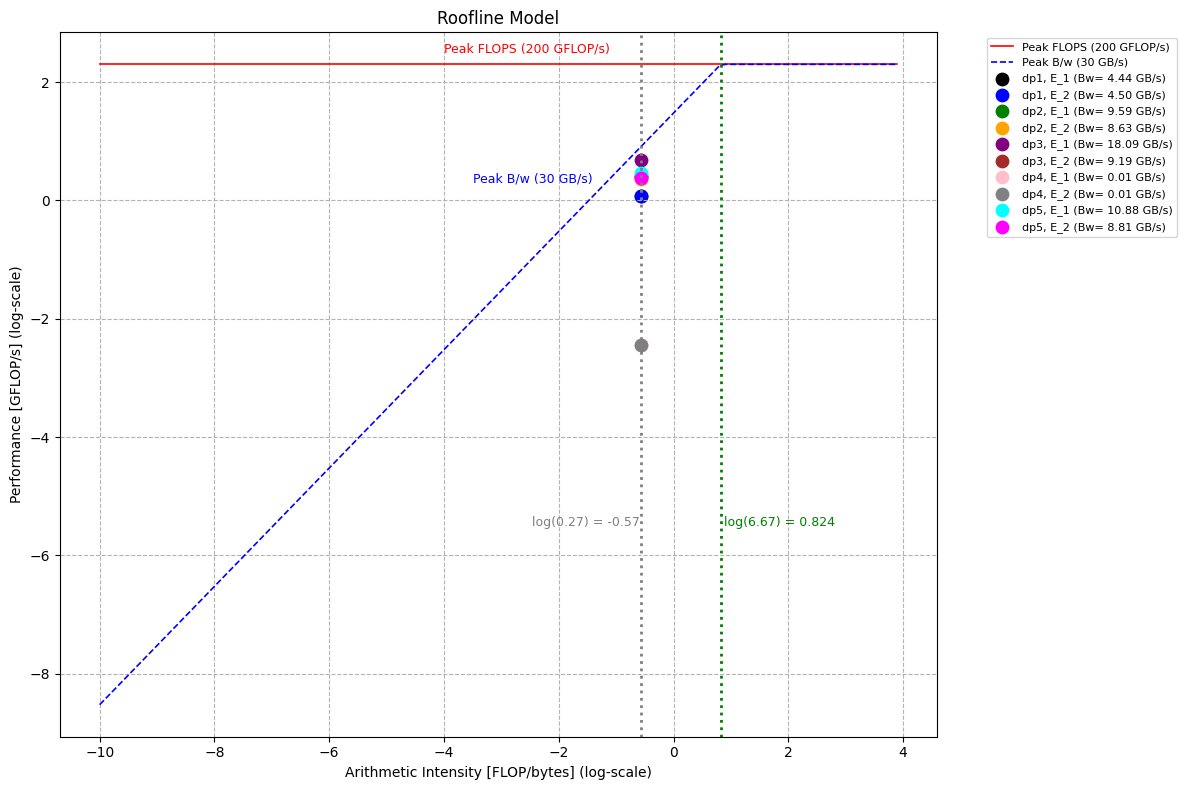

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def compute_avg_ai(results, bw):
    """Compute the average Arithmetic Intensity."""
    return np.mean(results) / np.mean(bw)

def plot_roofline(log_ai, peak_cpu, peak_mem, results, bw, avg_ai):
    """Plot the Roofline Model."""
    # Roofline values
    log_peak_cpu = np.full_like(log_ai, np.log10(peak_cpu))
    log_peak_mem = np.minimum(log_ai + np.log10(peak_mem), np.log10(peak_cpu))
    log_ai_peak_corrected = np.log10(peak_cpu / peak_mem)

    colors = ['black', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot Peak FLOPS and Peak Bandwidth
    ax.plot(log_ai, log_peak_cpu, 'r-', label=f'Peak FLOPS ({peak_cpu} GFLOP/s)', linewidth=1.2)
    ax.plot(log_ai, log_peak_mem, 'b--', label=f'Peak B/w ({peak_mem} GB/s)', linewidth=1.2)

    # Memory-bound and Compute-bound vertical lines
    ax.axvline(x=log_ai_peak_corrected, color='g', linestyle=':', linewidth=2)
    ax.axvline(x=np.log10(avg_ai), color='gray', linestyle=':', linewidth=2)

    # Annotations and labels
    annotations = [
        (f'Peak FLOPS ({peak_cpu} GFLOP/s)', (-4, np.log10(peak_cpu) + 0.2), 'red'),
        (f'Peak B/w ({peak_mem} GB/s)', (-3.5, 0.3), 'blue'),
        (f'log(6.67) = {log_ai_peak_corrected:.3f}', (log_ai_peak_corrected + 0.05, -5.5), 'green'),
        (f'log({avg_ai:.2f}) = {np.log10(avg_ai):.2f}', (-2.47, -5.5), 'gray')
    ]
    for text, position, color in annotations:
        ax.annotate(text, xy=position, color=color, fontsize=9)

  # Scatter plot for Observed Values
    for idx, (flops, bandwidth, color) in enumerate(zip(results, bw, colors)):
        ax.scatter(np.log10(avg_ai), np.log10(flops), color=color, marker='o', s=80, label=f'dp{idx//2 + 1}, E_{idx%2 + 1} (Bw= {bandwidth:.2f} GB/s)')

    # Plot adjustments
    ax.set_xlabel('Arithmetic Intensity [FLOP/bytes] (log-scale)')
    ax.set_ylabel('Performance [GFLOP/s] (log-scale)')
    ax.set_title('Roofline Model')
    ax.legend(loc='upper left', fontsize=8, bbox_to_anchor=(1.05, 1))
    ax.grid(True, which="both", ls="--", c='0.7')
    plt.tight_layout()
    plt.show()

# Constants
PEAK_CPU = 200  # GFLOPS
PEAK_MEM = 30  # GB/s
LOG_AI = np.arange(-10.0, 4.0, 0.1)  # Range of arithmetic intensity in log scale

# Data from microbenchmarks
RESULTS = np.array([1191738180.203, 1207793347.447, 2574610957.554, 2315727082.634,
                    4854645953.298, 2466717159.903, 3626885.618, 3652346.133,
                    2921165255.164, 2366349779.493]) / 10**9  # Convert to GFLOP/sec
BW = [4.440, 4.499, 9.591, 8.627, 18.085, 9.189, 0.014, 0.014, 10.882, 8.815]

# Compute average AI
AVG_AI = compute_avg_ai(RESULTS, BW)

# Plot the roofline model
plot_roofline(LOG_AI, PEAK_CPU, PEAK_MEM, RESULTS, BW, AVG_AI)

**Q3.** Using the N = 300000000 simple loop as the baseline, explain the difference in performance for the 5 measurements in the C and Python variants.

Our dp4 implementation represents the simple loop dot product implementation in Python, it is the most straightforward and naïve approach to compute the dot product using a for loop without external libraries or optimizations. Given its interpreted nature and lack of optimizations, we should expect it to be the slowest and poorest performer of the five implementations and we can compare it to the other four implementations (dp1, dp2, dp3, dp5) to highlight the performance gains achieved by other methods.

**dp1** (Basic Dot Product in C) vs **dp4** (Simple Loop in Python):

*   Time: dp1 is significantly faster than dp4 at 0.490266 seconds vs 159.478333 seconds
*   Bandwidth: dp1 achieves a bandwidth of 4.559 GB/sec, which is much higher than the 0.014 GB/sec of dp4
*   FLOP/sec: dp1 has a throughput of 1.223 billion FLOP/sec, while dp4 achieves a mere 3.76 million FLOP/sec
*   Scaling: as the vector size increases from 1M to 300M, dp1 bandwidth remains consistent, indicating a scalable implementation in C.

The vast difference in performance is because C is a compiled language that can be heavily optimized by the compiler, whereas Python is interpreted and not optimized for such operations.


**dp2** (Dot Product with Loop Unrolling in C) vs **dp4** (Simple Loop in Python):

*   Time: dp2 is even faster than dp1, with a timing of 0.257274 seconds
*   Bandwidth: dp2 achieves a bandwidth of 8.688 GB/sec, which is superior to both dp1 and dp4
*   FLOP/sec: dp2 has a throughput of 2.332 billion FLOP/sec, which is superior to dp1 and dp4
*   Scaling: dp2 bandwidth slightly decreases as the vector size grows, suggesting that while loop unrolling provides benefits for smaller vectors, its efficiency diminishes slightly with larger data sizes.

Loop unrolling is an optimization technique where multiple iterations of a loop are combined into a single iteration to reduce the overhead of loop control, this results in faster execution despite increasing the code size.


**dp3** (Dot Product using MKL in C) vs **dp4** (Simple Loop in Python):

*   Time: dp3 achieves the best C performance at 0.210301 seconds, better than dp1, dp2, dp4, and dp5
*   Bandwidth: dp3 achieves a bandwidth of 10.628 GB/sec, which is superior to dp1, dp2, dp4, and dp5
*   FLOP/sec: dp3 has a throughput of 2.853 billion FLOP/sec, which is superior to dp1, dp2, dp4, and dp5
*   Scaling: despite its excellent performance at 1M, dp3 bandwidth drops significantly as the vector size increases, indicating some scaling challenges when using the MKL library for very large vectors.

The optimized MKL library is a set of highly optimized mathematical routines. The cblas_sdot function from MKL performs the dot product, showcasing the power of using specialized libraries for mathematical operations.


**dp5** (numpy.dot in Python) vs **dp4** (Simple Loop in Python):

*   Time: dp5 outperforms dp4 and closely rivals the exceptional performance of MKL, at 0.218039 seconds
*   Bandwidth: dp5 achieves a highly optimized bandwidth of 10.299 GB/sec, superior to dp1, dp2, and dp4
*   FLOP/sec: dp5 has a throughput of 2.764 billion FLOP/sec, which is superior to dp1, dp2, and dp4
*   Scaling: dp5 bandwidth slightly decreases as the vector size grows, but it remains highly competitive, showcasing the optimization capabilities of NumPy even for larger data sizes.

The performance observed in dp5 is a testament to the efficiencies of NumPy, which provides Python bindings to underlying C implementations and demonstrates how using the right libraries can yield results that rival optimized C code.

Overall, the C implementations (dp1, dp2, dp3) are all significantly faster than the pure Python loop (dp4). Among the C implementations, using specialized libraries (dp3) or optimization techniques (dp2) can further boost performance. Additionally, the NumPy implementation (dp5) provides near-C performance, demonstrating the power of optimized libraries in Python, while pure Python loops (dp4) proved unsuitable for intensive numerical operations due to their significant performance limitations compared to optimized C or library-based solutions.


**Q4.** Check the result of the dotproduct computations against the analytically calculated result. Explain your findings. (Hint: Floating point operations are not exact.)

Because of the finite number of bits allocated to represent numbers, floating point arithmetic cannot precisely represent all integers beyond a certain magnitude. This limitation can lead to unexpected behaviors when performing large-scale computations, but can be mitigated by employing strategies like chunking or leveraging optimized libraries to achieve results that are much closer to the analytically expected values.

In the realm of computational mathematics, the task involves computing the dot product of two vectors of size *N*, with each element initialized to 1.

Analytically, the dot product for such vectors can be represented as:

$$ A \cdot B = \sum_{i=1}^{N} A_i \times B_i = \sum_{i=1}^{N} 1 \times 1 = N $$

Here, we will examine the findings from our dot product computations, based on how these precision issues have been handled by splitting the dot product into chunks after our initial tests demonstrated precision issues that are typical of floating point arithmetic.

*   **dp1** (Dot Product in C) and **dp2** (Dot Product with Loop Unrolling in C):
  *   Without optimization techniques like chunking, the value for the dot product in dp1 saturates at 16777216. This is not because of the nature of the dot product but rather due to the limitations of single-precision floating-point arithmetic.
  *   This saturation is due to the inability of single-precision floating-point arithmetic to accurately represent integers beyond $2^{24}$.
  *   In dp1_test (below), the operation continuously adds 1 to the running sum. When the sum reaches $2^{24}$ (16777216) any further addition does not change the value because of precision limitation. In this case, it is as if there is an error of -1 causing the results to stay the same, even though we are trying to add 1.
  *   dp2_test (below) uses a loop unrolling to add 4 in each iteration. However, when the sum reaches ${4} \cdot 2^{24}$ (67108864), adding 4 does not change the result. Again, this is due to the precision limitation and can be thought of as an error of -4.
  *   In our final versions of dp1 and dp2, a chunking strategy breaks down the dot product into smaller chunks, effectively preventing the sum in any chunk from reaching the problematic threshold. As a result, with chunking, our results align with the expected value (*R* = *N*), demonstrating the effectiveness of this strategy in mitigating floating-point precision issues.
  *   Loop unrolling in dp2 also improves performance, underscoring the advantage of this optimization in computational tasks that are both memory-bound and computationally intensive.

*   **dp3** (Intel MKL in C): The MKL library features optimizations that handle precision loss more effectively than our straightforward implementation. The dot product results matched the expected analytical value without additional optimizations. The larger vector sizes were slower but still performed well with limited variability in each run and the MKL performance proved superior to the unrolled loop in dp2.

*   **dp4** (Simply Loop in Python): Python uses double precision for its floating point operations, which provides a larger range of exact integer representations with its allocation of 64 bits. This is crucial for iterative computations where errors can accumulate over time, double precision ensures that results are accurate and reliable for tasks that require greater precision. However, as was observed during our tests, this increased accuracy comes at the expense of increased memory usage and potentially slower runtimes, especially when using hardware that has been optimized for single precision. Because of this, the dot product computation returned results matching the analytical value without needing additional optimization but the performance in Python was slower than the previous C-based implementations.

*   **dp5** (numpy.dot in Python): NumPy is also optimized for numerical computaitons and uses a combination of efficient algorithms and higher precision arithmetic when computing the dot product. Thus, the results were consistent with expected analytical values without needing further optimization. The NumPy built-in dot function proved faster than the generic Python loop in dp4, and the performance of dp5 proved closer to the C-based implementations.

In conclusion, the nuances of single-precision floating-point operations can lead to significant precision losses, especially with larger numbers. This precision loss can materially impact the outcome of computations, as evidenced in dp1 and dp2 without chunking. By understanding these computational intricacies and employing strategies like chunking or optimized libraries, we can achieve results that are closer to the analytically expected values.

Validation tests were executed after running each expirement, the results of the dot product computations against the analytically calculated result were as follows:

**dp1**

For N = 1000000:  
Computed Dot Product: 1000000.0  
Analytical Result: 1000000

For N = 16777216:  
Computed Dot Product: 16777216.0  
Analytical Result: 16777216

For N = 67108864:  
Computed Dot Product: 67108864.0  
Analytical Result: 67108864

For N = 300000000:  
Computed Dot Product: 300000000.0  
Analytical Result: 300000000  


**dp2**

For N = 1000000:  
Computed Dot Product: 1000000.0  
Analytical Result: 1000000  

For N = 16777216:  
Computed Dot Product: 16777216.0  
Analytical Result: 16777216  

For N = 67108864:  
Computed Dot Product: 67108864.0  
Analytical Result: 67108864  

For N = 300000000:  
Computed Dot Product: 300000000.0  
Analytical Result: 300000000  


**dp3**

For N = 1000000:  
Computed Dot Product (using MKL): 1000000.0  
Analytical Result: 1000000  

For N = 16777216:  
Computed Dot Product (using MKL): 16777216.0  
Analytical Result: 16777216  

For N = 67108864:  
Computed Dot Product (using MKL): 67108864.0  
Analytical Result: 67108864  

For N = 300000000:  
Computed Dot Product (using MKL): 300000000.0  
Analytical Result: 300000000  


**dp4**

For N = 1000000:  
Computed Dot Product (using Python loop): 1000000.0  
Analytical Result: 1000000  

For N = 16777216:  
Computed Dot Product (using Python loop): 16777216.0  
Analytical Result: 16777216  

For N = 67108864:  
Computed Dot Product (using Python loop): 67108864.0  
Analytical Result: 67108864  

For N = 300000000:  
Computed Dot Product (using Python loop): 300000000.0  
Analytical Result: 300000000  


**dp5**

For N = 1000000:  
Computed Dot Product (using numpy.dot): 1000000.0  
Analytical Result: 1000000  

For N = 16777216:  
Computed Dot Product (using numpy.dot): 16777216.0  
Analytical Result: 16777216  

For N = 67108864:  
Computed Dot Product (using numpy.dot): 67108864.0  
Analytical Result: 67108864  

For N = 300000000:  
Computed Dot Product (using numpy.dot): 300000000.0  
Analytical Result: 300000000  


In [15]:
%%writefile dp1_test.c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#define GB (1073741824.0)

// Compute the dot product of two vectors
float dp(long N, float *pA, float *pB)
{
    float R = 0.0;
    int j;
    for (j = 0; j < N; j++)
        R += pA[j] * pB[j]; // Multiply corresponding elements and accumulate
    return R;
}

// Initialize two vectors with all elements set to 1
void initialize_vectors(long N, float *vecA, float *vecB)
{
    for (long i = 0; i < N; i++)
    {
        vecA[i] = 1.0;
        vecB[i] = 1.0;
    }
}

int main(int argc, char *argv[])
{
    // Check for the correct number of command-line arguments
    if (argc < 3)
    {
        printf("Usage: %s [vector size] [number of measurements]\n", argv[0]);
        return 1;
    }

    // Convert command-line arguments to respective data types
    long vec_size = atol(argv[1]);
    int num_measurements = atoi(argv[2]);
    printf("Vector size: %ld with %d measurements.\n", vec_size, num_measurements);

    // Allocate memory for the two vectors
    float *vecA = (float *)malloc(vec_size * sizeof(float));
    float *vecB = (float *)malloc(vec_size * sizeof(float));

    // Measure the time
    struct timespec start_time, end_time;
    double cumulative_time = 0;
    float dp_result;

    // Initialize vectors to default values
    initialize_vectors(vec_size, vecA, vecB);

    // Perform the dot product multiple times and measure its performance
    for (int i = 0; i < num_measurements; i++)
    {
        clock_gettime(CLOCK_MONOTONIC, &start_time); // Start the timer
        dp_result = dp(vec_size, vecA, vecB);
        clock_gettime(CLOCK_MONOTONIC, &end_time); // Stop the timer

        // Calculate elapsed time
        double elapsed_time = (end_time.tv_sec - start_time.tv_sec) +
                              (end_time.tv_nsec - start_time.tv_nsec) / 1e9;

        // Accumulate time from the second half measurements for averages
        if (i >= num_measurements / 2)
            cumulative_time += elapsed_time;

        // Compute bandwidth and flops
        double bandwidth = (vec_size * 2 * sizeof(float) / GB) / elapsed_time;
        double flops = vec_size * 2 / elapsed_time;

        printf("R: %ld <T>: %.6f sec B: %.3f GB/sec F: %.3f FLOP/sec\n",
                (long)dp_result, elapsed_time, bandwidth, flops);

    }

    // Calculate and print the averages for second half measurements
    double average_time = cumulative_time / (num_measurements / 2);
    double average_bandwidth = (vec_size * 2 * sizeof(float) / GB) / average_time;
    double average_flops = vec_size * 2 / average_time;

    printf("N: %li <T>: %.6f sec B: %.3f GB/sec F: %.3f FLOP/sec\n",
           vec_size, average_time, average_bandwidth, average_flops);

    // Free the allocated memory
    free(vecA);
    free(vecB);

    return 0;
}

Overwriting dp1_test.c


In [16]:
!gcc -O3 -Wall -o dp1_test dp1_test.c

In [17]:
!./dp1_test

Usage: ./dp1_test [vector size] [number of measurements]


In [18]:
!./dp1_test 1000000 1000

Vector size: 1000000 with 1000 measurements.
R: 1000000 <T>: 0.002307 sec B: 3.230 GB/sec F: 867086105.119 FLOP/sec
R: 1000000 <T>: 0.001630 sec B: 4.570 GB/sec F: 1226771841.906 FLOP/sec
R: 1000000 <T>: 0.001625 sec B: 4.584 GB/sec F: 1230519340.688 FLOP/sec
R: 1000000 <T>: 0.001976 sec B: 3.771 GB/sec F: 1012333768.468 FLOP/sec
R: 1000000 <T>: 0.001592 sec B: 4.679 GB/sec F: 1256069958.072 FLOP/sec
R: 1000000 <T>: 0.002232 sec B: 3.338 GB/sec F: 896152102.104 FLOP/sec
R: 1000000 <T>: 0.001616 sec B: 4.609 GB/sec F: 1237242483.443 FLOP/sec
R: 1000000 <T>: 0.001590 sec B: 4.687 GB/sec F: 1258098220.986 FLOP/sec
R: 1000000 <T>: 0.001668 sec B: 4.466 GB/sec F: 1198943730.573 FLOP/sec
R: 1000000 <T>: 0.002002 sec B: 3.722 GB/sec F: 999077352.065 FLOP/sec
R: 1000000 <T>: 0.002284 sec B: 3.262 GB/sec F: 875666327.346 FLOP/sec
R: 1000000 <T>: 0.001608 sec B: 4.633 GB/sec F: 1243719991.369 FLOP/sec
R: 1000000 <T>: 0.001847 sec B: 4.035 GB/sec F: 1083050476.651 FLOP/sec
R: 1000000 <T>: 0.00174

In [19]:
!./dp1_test 300000000 20

Vector size: 300000000 with 20 measurements.
R: 16777216 <T>: 0.484582 sec B: 4.613 GB/sec F: 1238180460.877 FLOP/sec
R: 16777216 <T>: 0.488808 sec B: 4.573 GB/sec F: 1227477024.085 FLOP/sec
R: 16777216 <T>: 0.485182 sec B: 4.607 GB/sec F: 1236649120.636 FLOP/sec
R: 16777216 <T>: 0.491634 sec B: 4.546 GB/sec F: 1220420840.607 FLOP/sec
R: 16777216 <T>: 0.489934 sec B: 4.562 GB/sec F: 1224655246.842 FLOP/sec
R: 16777216 <T>: 0.484750 sec B: 4.611 GB/sec F: 1237751262.501 FLOP/sec
R: 16777216 <T>: 0.491045 sec B: 4.552 GB/sec F: 1221885138.280 FLOP/sec
R: 16777216 <T>: 0.482985 sec B: 4.628 GB/sec F: 1242274373.315 FLOP/sec
R: 16777216 <T>: 0.491989 sec B: 4.543 GB/sec F: 1219539161.314 FLOP/sec
R: 16777216 <T>: 0.490109 sec B: 4.561 GB/sec F: 1224217599.879 FLOP/sec
R: 16777216 <T>: 0.492591 sec B: 4.538 GB/sec F: 1218048845.598 FLOP/sec
R: 16777216 <T>: 0.484841 sec B: 4.610 GB/sec F: 1237520240.030 FLOP/sec
R: 16777216 <T>: 0.491240 sec B: 4.550 GB/sec F: 1221397790.023 FLOP/sec
R: 167

In [25]:
%%writefile dp2_test.c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#define GB (1073741824.0)

// Compute the dot product of two vectors
// This version unrolls the loop for better performance
float dpunroll(long N, float *pA, float *pB)
{
    float R = 0.0;
    int j;
    for (j = 0; j < N; j += 4)
        // The loop is unrolled to calculate 4 products in a single iteration
        R += pA[j] * pB[j] + pA[j + 1] * pB[j + 1] +
             pA[j + 2] * pB[j + 2] + pA[j + 3] * pB[j + 3];
    return R;
}

// Initialize two vectors with all elements set to 1
void initialize_vectors(long N, float *vecA, float *vecB)
{
    for (long i = 0; i < N; i++)
    {
        vecA[i] = 1.0;
        vecB[i] = 1.0;
    }
}

int main(int argc, char *argv[])
{
    // Check for the correct number of command-line arguments
    if (argc < 3)
    {
        printf("Usage: %s [vector size] [number of measurements]\n", argv[0]);
        return 1;
    }

    // Convert command-line arguments to respective data types
    long vec_size = atol(argv[1]);
    int num_measurements = atoi(argv[2]);
    printf("Vector size: %ld with %d measurements.\n", vec_size, num_measurements);

    // Allocate memory for the two vectors
    float *vecA = (float *)malloc(vec_size * sizeof(float));
    float *vecB = (float *)malloc(vec_size * sizeof(float));

    // Measure the time
    struct timespec start_time, end_time;
    double cumulative_time = 0;
    float dp_result;

    // Initialize vectors to default values
    initialize_vectors(vec_size, vecA, vecB);

    // Perform the dot product multiple times and measure its performance
    for (int i = 0; i < num_measurements; i++)
    {
        clock_gettime(CLOCK_MONOTONIC, &start_time); // Start the timer
        dp_result = dpunroll(vec_size, vecA, vecB); // Loop-unrolled dot product function
        clock_gettime(CLOCK_MONOTONIC, &end_time); // Stop the timer

        // Calculate elapsed time
        double elapsed_time = (end_time.tv_sec - start_time.tv_sec) +
                              (end_time.tv_nsec - start_time.tv_nsec) / 1e9;

        // Accumulate time from the second half measurements for average calculation
        if (i >= num_measurements / 2)
            cumulative_time += elapsed_time;

        // Compute bandwidth and flops
        double bandwidth = (vec_size * 2 * sizeof(float) / GB) / elapsed_time;
        double flops = vec_size * 2 / elapsed_time;

        printf("R: %ld <T>: %.6f sec B: %.3f GB/sec F: %.3f FLOP/sec\n",
                (long)dp_result, elapsed_time, bandwidth, flops);
    }

    // Calculate and print the averages for second half measurements
    double average_time = cumulative_time / (num_measurements / 2);
    double average_bandwidth = (vec_size * 2 * sizeof(float) / GB) / average_time;
    double average_flops = vec_size * 2 / average_time;

    printf("N: %li <T>: %.6f sec B: %.3f GB/sec F: %.3f FLOP/sec\n",
           vec_size, average_time, average_bandwidth, average_flops);

    // Free the allocated memory
    free(vecA);
    free(vecB);

    return 0;
}

Overwriting dp2_test.c


In [26]:
!gcc -O3 -Wall -o dp2_test dp2_test.c

In [27]:
!./dp2_test

Usage: ./dp2_test [vector size] [number of measurements]


In [28]:
!./dp2_test 1000000 1000

Vector size: 1000000 with 1000 measurements.
R: 1000000 <T>: 0.001299 sec B: 5.735 GB/sec F: 1539461003.913 FLOP/sec
R: 1000000 <T>: 0.001362 sec B: 5.470 GB/sec F: 1468391047.220 FLOP/sec
R: 1000000 <T>: 0.001256 sec B: 5.933 GB/sec F: 1592549416.808 FLOP/sec
R: 1000000 <T>: 0.001127 sec B: 6.609 GB/sec F: 1774057775.740 FLOP/sec
R: 1000000 <T>: 0.001212 sec B: 6.149 GB/sec F: 1650678470.118 FLOP/sec
R: 1000000 <T>: 0.000924 sec B: 8.066 GB/sec F: 2165123114.313 FLOP/sec
R: 1000000 <T>: 0.000842 sec B: 8.852 GB/sec F: 2376293149.028 FLOP/sec
R: 1000000 <T>: 0.000772 sec B: 9.655 GB/sec F: 2591851994.884 FLOP/sec
R: 1000000 <T>: 0.000848 sec B: 8.788 GB/sec F: 2358963471.451 FLOP/sec
R: 1000000 <T>: 0.000759 sec B: 9.813 GB/sec F: 2634032756.831 FLOP/sec
R: 1000000 <T>: 0.000712 sec B: 10.466 GB/sec F: 2809312308.440 FLOP/sec
R: 1000000 <T>: 0.000711 sec B: 10.479 GB/sec F: 2812975129.080 FLOP/sec
R: 1000000 <T>: 0.000684 sec B: 10.894 GB/sec F: 2924387048.475 FLOP/sec
R: 1000000 <T>: 

In [29]:
!./dp2_test 300000000 20

Vector size: 300000000 with 20 measurements.
R: 67108864 <T>: 0.305742 sec B: 7.311 GB/sec F: 1962440889.604 FLOP/sec
R: 67108864 <T>: 0.311067 sec B: 7.186 GB/sec F: 1928847918.587 FLOP/sec
R: 67108864 <T>: 0.309553 sec B: 7.221 GB/sec F: 1938280722.515 FLOP/sec
R: 67108864 <T>: 0.306531 sec B: 7.292 GB/sec F: 1957387427.762 FLOP/sec
R: 67108864 <T>: 0.306774 sec B: 7.286 GB/sec F: 1955836858.210 FLOP/sec
R: 67108864 <T>: 0.306587 sec B: 7.291 GB/sec F: 1957030492.606 FLOP/sec
R: 67108864 <T>: 0.304735 sec B: 7.335 GB/sec F: 1968923043.724 FLOP/sec
R: 67108864 <T>: 0.258050 sec B: 8.662 GB/sec F: 2325129274.863 FLOP/sec
R: 67108864 <T>: 0.252432 sec B: 8.855 GB/sec F: 2376879861.408 FLOP/sec
R: 67108864 <T>: 0.265831 sec B: 8.408 GB/sec F: 2257076363.243 FLOP/sec
R: 67108864 <T>: 0.257332 sec B: 8.686 GB/sec F: 2331622267.151 FLOP/sec
R: 67108864 <T>: 0.264618 sec B: 8.447 GB/sec F: 2267422500.368 FLOP/sec
R: 67108864 <T>: 0.265063 sec B: 8.433 GB/sec F: 2263615132.881 FLOP/sec
R: 671